In [1]:
%matplotlib inline

import torch
import torch.nn.functional as F
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn
from laughter_prediction.predictors import RnnPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
!mkdir -p data

## Cмотирим на данные

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


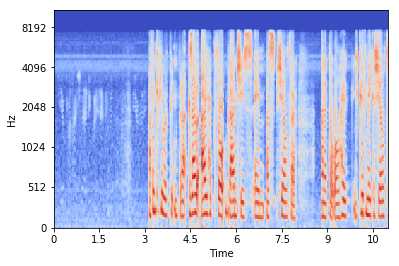

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

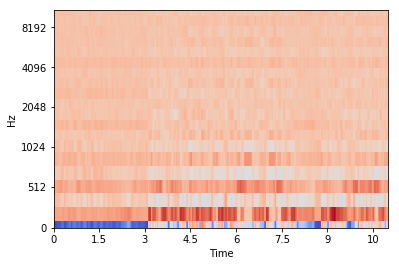

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


## Считываем признаки

In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

/home/maxim/PycharmProjects/speech-ml-hw/2/homework/laughter_classification/sspnet_data_sampler.py:112: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return pd.DataFrame.from_csv(save_path, index_col=None)


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-19.512337,-10.751633,-14.777827,-18.966939,-16.917103,-18.246705,-20.162993,-18.075304,-17.600648,-18.778584,...,8.756960,-14.857754,22.649179,-15.996658,12.870518,-10.768023,6.965929,-3.087592,0,S0001
1,-16.418212,-11.479087,-15.647148,-18.000653,-16.257974,-18.293827,-19.216450,-17.100311,-17.355976,-18.953886,...,9.974392,-17.866732,21.224710,-12.295156,15.577631,-11.913397,5.912433,-2.406997,0,S0001
2,-19.561318,-14.155631,-16.500950,-19.259373,-15.947509,-18.508480,-17.752083,-18.735773,-20.000116,-18.555955,...,11.887583,-15.699741,18.171677,-13.792290,8.600648,-10.910454,7.183778,-5.662854,0,S0001
3,-19.069293,-13.010108,-17.266277,-16.038272,-13.717408,-16.670910,-19.712922,-18.614219,-19.417061,-19.828697,...,6.627427,-9.134603,24.201275,-19.071646,13.919328,-5.860380,2.450502,-8.587574,0,S0001
4,-15.080133,-9.803062,-15.000448,-16.308712,-16.056597,-17.036844,-19.208406,-17.545893,-20.549559,-17.875918,...,12.126552,-17.691907,21.201253,-14.738738,12.562647,-8.362024,5.665779,-4.746374,0,S0001
5,-16.768311,-10.336495,-15.832604,-16.880480,-14.970650,-18.038281,-20.697990,-19.351725,-21.673575,-21.253379,...,11.975913,-12.901809,24.117082,-15.677362,14.176729,-4.046529,2.868359,-8.642527,0,S0001
6,-18.152393,-13.111996,-18.351703,-17.225439,-14.967807,-18.456091,-17.151680,-15.648074,-16.994343,-18.038206,...,7.246362,-14.432793,20.468048,-17.810742,9.385266,-9.466130,3.346170,-5.362977,0,S0001
7,-17.162352,-12.888983,-17.996707,-19.491615,-18.377252,-16.595850,-18.217371,-17.095571,-16.184384,-17.890604,...,9.661401,-15.591358,22.338917,-16.937508,8.823653,-13.398335,4.027778,-3.166383,0,S0001
8,-21.760583,-17.076791,-17.519815,-17.840089,-15.205841,-15.410737,-19.382010,-16.272773,-15.181722,-17.153874,...,6.881137,-13.332776,20.765922,-16.207669,8.292226,-13.345987,1.548566,-2.481757,0,S0001
9,-20.976208,-13.166227,-16.969717,-15.078048,-15.592011,-20.803412,-18.955738,-17.210551,-20.674733,-21.714713,...,12.389687,-14.276152,22.001954,-17.787656,13.491517,-8.972144,4.211393,-4.558085,0,S0001


In [11]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus_noisy_2')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy_2.csv')

In [12]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,10.439375,8.166172,1.787343,0.961609,0.518251,0.464785,5.940004,4.732757,4.939084,5.496507,...,6.693442,-11.973558,7.150050,-6.267481,10.497273,-12.915785,8.740633,9.074363,0,S0001
1,4.214703,8.075847,1.559017,-1.940547,1.403326,3.353881,7.548226,4.186003,2.652214,5.195771,...,2.727214,-13.905526,7.403936,-9.058948,9.081893,-7.995094,6.641132,3.317221,0,S0001
2,3.450489,7.706800,4.059098,1.855232,0.719113,2.182044,5.040138,5.347765,5.370654,6.265171,...,8.247667,-11.805309,6.371170,-7.856377,7.630264,-9.810210,7.772787,4.375901,0,S0001
3,5.561931,7.588067,1.510005,-1.733389,-1.299166,0.477881,4.574728,2.833029,4.859122,6.362141,...,0.230917,-12.271124,11.751942,-11.081493,4.893829,-6.404770,11.517457,3.516976,0,S0001
4,6.332487,7.019075,1.935890,2.248774,3.163043,0.984186,5.826662,3.069556,1.411427,4.045337,...,8.081160,-14.971185,5.849953,-8.608963,8.351795,-8.722728,7.937342,3.385792,0,S0001
5,6.117652,9.780912,4.205653,2.027693,0.629670,1.600355,6.365960,3.217295,0.862780,3.281168,...,5.991313,-11.880992,8.421637,-9.228018,9.534089,-5.466217,7.101127,5.614264,0,S0001
6,6.268359,8.070545,2.826578,2.210052,1.505526,2.239051,5.780330,5.425508,5.969553,6.014756,...,3.951274,-13.804472,5.858026,-6.610253,5.541875,-6.871681,5.227476,3.919196,0,S0001
7,5.988946,8.389796,3.011688,1.839174,-0.357400,2.435814,6.750822,3.307585,4.471572,5.128310,...,2.453321,-11.538826,7.357164,-4.615799,7.020939,-7.778018,5.868335,7.281755,0,S0001
8,6.183594,8.754832,3.611261,0.672525,0.547362,1.580932,3.757773,2.562096,2.818159,2.799829,...,3.758517,-13.818702,9.979484,-8.640366,6.377983,-5.681431,9.992364,7.128073,0,S0001
9,7.589022,9.450245,2.692876,1.161503,2.204125,0.454611,5.410889,2.751609,4.244760,5.225402,...,8.919660,-15.388419,7.033007,-10.901056,9.709240,-6.695360,9.332455,6.167759,0,S0001


In [13]:
laughter_precentage = np.average(data['IS_LAUGHTER']) * 100.
print(f"laughter precentage {laughter_precentage}%")

laughter precentage 3.5872435506804794%


## Нормализуем признаки

In [14]:
data_noisy.iloc[:,:-2].head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,10.439375,8.166172,1.787343,0.961609,0.518251,0.464785,5.940004,4.732757,4.939084,5.496507,...,-1.401255,-7.107489,6.693442,-11.973558,7.150050,-6.267481,10.497273,-12.915785,8.740633,9.074363
1,4.214703,8.075847,1.559017,-1.940547,1.403326,3.353881,7.548226,4.186003,2.652214,5.195771,...,-2.680928,-6.029506,2.727214,-13.905526,7.403936,-9.058948,9.081893,-7.995094,6.641132,3.317221
2,3.450489,7.706800,4.059098,1.855232,0.719113,2.182044,5.040138,5.347765,5.370654,6.265171,...,-4.979736,-9.373904,8.247667,-11.805309,6.371170,-7.856377,7.630264,-9.810210,7.772787,4.375901
3,5.561931,7.588067,1.510005,-1.733389,-1.299166,0.477881,4.574728,2.833029,4.859122,6.362141,...,-2.948774,-7.246780,0.230917,-12.271124,11.751942,-11.081493,4.893829,-6.404770,11.517457,3.516976
4,6.332487,7.019075,1.935890,2.248774,3.163043,0.984186,5.826662,3.069556,1.411427,4.045337,...,-3.623598,-3.345864,8.081160,-14.971185,5.849953,-8.608963,8.351795,-8.722728,7.937342,3.385792


In [15]:
scaler = MinMaxScaler()
scaler.fit(data_noisy.iloc[:,:-2])

data_noisy.iloc[:,:-2] = scaler.transform(data_noisy.iloc[:,:-2])
data.iloc[:,:-2] = scaler.transform(data.iloc[:,:-2])

In [16]:
data.head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,0.029122,0.224257,0.143292,0.055819,0.079772,0.068982,0.036124,0.057871,0.071725,0.075034,...,0.565301,0.382105,0.708587,0.329580,0.541014,0.340178,0.493872,0.382460,0,S0001
1,0.097689,0.206482,0.124469,0.073910,0.091229,0.068219,0.051690,0.073655,0.075633,0.072335,...,0.583397,0.335016,0.686975,0.391559,0.589253,0.322816,0.477087,0.394031,0,S0001
2,0.028037,0.141083,0.105982,0.050344,0.096625,0.064744,0.075772,0.047178,0.033402,0.078462,...,0.611835,0.368929,0.640657,0.366490,0.464929,0.338019,0.497342,0.338680,0,S0001
3,0.038940,0.169073,0.089410,0.110649,0.135389,0.094492,0.043525,0.049146,0.042714,0.058868,...,0.533646,0.471670,0.732134,0.278092,0.559703,0.414568,0.421929,0.288958,0,S0001
4,0.127341,0.247434,0.138472,0.105586,0.094729,0.088568,0.051822,0.066441,0.024627,0.088931,...,0.615388,0.337752,0.686620,0.350643,0.535528,0.376648,0.473157,0.354260,0,S0001


In [17]:
data_noisy.head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,0.692856,0.686496,0.501971,0.428920,0.382830,0.371891,0.465397,0.427114,0.431715,0.448754,...,0.534628,0.427242,0.473443,0.492488,0.498725,0.307622,0.522147,0.589219,0,S0001
1,0.554916,0.684289,0.497027,0.374586,0.398215,0.418661,0.491845,0.418263,0.395191,0.444124,...,0.475672,0.397007,0.477295,0.445747,0.473504,0.382210,0.488697,0.491345,0,S0001
2,0.537981,0.675272,0.551161,0.445650,0.386322,0.399691,0.450598,0.437071,0.438608,0.460587,...,0.557730,0.429875,0.461627,0.465883,0.447637,0.354696,0.506727,0.509343,0,S0001
3,0.584771,0.672371,0.495966,0.378464,0.351240,0.372103,0.442944,0.396359,0.430438,0.462080,...,0.438566,0.422585,0.543260,0.411881,0.398876,0.406316,0.566390,0.494741,0,S0001
4,0.601847,0.658468,0.505188,0.453018,0.428802,0.380299,0.463533,0.400189,0.375374,0.426413,...,0.555255,0.380330,0.453719,0.453281,0.460494,0.371180,0.509349,0.492511,0,S0001


## Обучаем модель на данных с шумом

In [18]:
def split(df, test_size=0.1, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=test_size)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

In [19]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data_noisy)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [21]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2]).head()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] S2336


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,0.543256,0.592297,0.536721,0.450643,0.410122,0.398408,0.365556,0.368547,0.383172,0.421722,...,0.509056,0.343565,0.599377,0.577598,0.568458,0.310478,0.469313,0.602203,0.314929,0.386038
1,0.601681,0.678586,0.585330,0.465666,0.420651,0.449987,0.464824,0.476236,0.441523,0.407947,...,0.608165,0.470718,0.417332,0.657591,0.484091,0.451662,0.421107,0.499522,0.468048,0.342416
2,0.722474,0.793675,0.703817,0.614731,0.601228,0.546542,0.582536,0.659590,0.703694,0.686764,...,0.396533,0.427827,0.511120,0.392583,0.580126,0.248907,0.451668,0.477406,0.369646,0.405604
3,0.692803,0.811384,0.754203,0.628384,0.575871,0.507972,0.648875,0.701754,0.713251,0.670910,...,0.402961,0.406632,0.466300,0.463083,0.633130,0.198384,0.336255,0.570886,0.241324,0.367445
4,0.468470,0.493893,0.446626,0.416466,0.387684,0.393891,0.406496,0.345986,0.373547,0.384979,...,0.714048,0.399987,0.463107,0.689255,0.569958,0.274453,0.542596,0.445743,0.318217,0.431514


In [22]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1024, 'cuda')

In [24]:
def window_mean(arr, k=5):
    return np.convolve(arr,np.ones(k, dtype=float) / k,'valid')

In [31]:
class TrainingStats:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_auc = []
        self.train_auc = []
        self.test_f1 = []
        self.train_f1 = []
        
    def plot(self):
        plt.plot(window_mean(self.train_losses), label='train_loss')
        plt.plot(window_mean(self.test_losses), label='test_loss')
        plt.legend()
        plt.show()

        plt.plot(window_mean(self.train_auc), label='train_auc')
        plt.plot(window_mean(self.test_auc), label='test_auc')
        plt.legend()
        plt.show()
        
        plt.plot(window_mean(self.train_f1), label='train_f1')
        plt.plot(window_mean(self.test_f1), label='test_f1')
        plt.legend()
        plt.show()

In [38]:
model_noisy = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_noisy = model_noisy.to(device)
train_iter = 1


def train_model(model, X_train, y_train, X_test, y_test, batch_size, iters=100, lr=5e-4, stats=None):
    if stats is None:
        stats = TrainingStats()
    
    model.set_batch_size(batch_size)
    
    y_positive = np.average(y_train)
        
    def calc_loss(pred_both, pred_mfcc, y):
        y = y.reshape(-1)
        return F.nll_loss(pred_both.reshape(-1, 2), y) + \
               F.nll_loss(pred_mfcc.reshape(-1, 2), y) 
    
    n_train = batch_size
    n_test = len(X_test)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    def calc_auc(y_actual, y_score):
        return float(roc_auc_score(y_actual.ravel(), y_score.ravel()))
    
    def calc_f1(y_actual, y_score, threshold=0.5):
        y_actual = y_actual.ravel().astype(np.int)
        y_score = y_score.ravel()
        
        y_pred = np.zeros_like(y_score, dtype=np.int)
        y_pred[y_score > threshold] = 1
        
        if np.sum(y_pred * y_actual) == 0:
            return 0.
        
        p = np.average(y_actual[y_pred == 1])
        r = np.average(y_pred[y_actual == 1])
        return float(2. / (1. / p + 1. / r))
    
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).to(device)
    
    global train_iter
    def append_stats(train_loss, train_pred, train_y_actual):
        with torch.no_grad():
            model.set_batch_size(n_test)
            
            test_pred_both, test_pred_mfcc = model.forward(X_test_tensor, device)
            test_loss = calc_loss(test_pred_both, test_pred_mfcc, y_test_tensor)
            test_loss = test_loss.cpu().detach().numpy()
            
            test_pred = test_pred_both.cpu().detach().numpy()
            test_score = np.exp(test_pred[:,:,1])
            train_score = np.exp(train_pred[:,:,1])
            
            stats.test_losses.append(float(test_loss))
            stats.train_losses.append(float(train_loss))
            stats.test_auc.append(calc_auc(y_test, test_score))
            stats.train_auc.append(calc_auc(train_y_actual, train_score))
            stats.test_f1.append(calc_f1(y_test, test_score))
            stats.train_f1.append(calc_f1(train_y_actual, train_score))
            
    for _ in range(iters):
        model.train()
        model.zero_grad()
        model.set_batch_size(batch_size)
        
        indices = np.random.choice(n_train, batch_size, replace=False)
        X_batch = torch.tensor(X_train[indices])
        X_batch = X_batch.float().to(device)
        y_actual = torch.tensor(y_train[indices])
        y_actual = y_actual.to(device)
        
        pred_both, pred_mfcc = model.forward(X_batch, device)
        
        train_loss = calc_loss(pred_both, pred_mfcc, y_actual)
        train_loss.backward()
        optimizer.step()
        
        train_loss = train_loss.cpu().detach().numpy()
        pred_both = pred_both.cpu().detach().numpy()
        y_actual = y_actual.cpu().detach().numpy()
        
        append_stats(train_loss, pred_both, y_actual)
        
        if train_iter % 50 == 0:
            train_loss = stats.train_losses[-1]
            test_loss  = stats.test_losses[-1]
            
            train_f1 = stats.train_f1[-1]
            test_f1 = stats.test_f1[-1]
            print(f"iter {train_iter} train_loss {train_loss} test_loss {test_loss}")
            print(f"iter {train_iter} train_f1 {train_f1} test_f1 {test_f1}")
            print()
            
        if train_iter % 500 == 0:
            stats.plot()
            
        train_iter += 1
    return stats

iter 50 train_loss 0.3480069935321808 test_loss 0.36315011978149414
iter 50 train_f1 0.0 test_f1 0.0

iter 100 train_loss 0.32954132556915283 test_loss 0.3431718051433563
iter 100 train_f1 0.0 test_f1 0.0

iter 150 train_loss 0.311024010181427 test_loss 0.3258330821990967
iter 150 train_f1 0.0 test_f1 0.0

iter 200 train_loss 0.29173821210861206 test_loss 0.3116292953491211
iter 200 train_f1 0.0 test_f1 0.0

iter 250 train_loss 0.2783023715019226 test_loss 0.29645729064941406
iter 250 train_f1 0.0 test_f1 0.0

iter 300 train_loss 0.26601943373680115 test_loss 0.28384649753570557
iter 300 train_f1 0.0 test_f1 0.0

iter 350 train_loss 0.258287250995636 test_loss 0.28295212984085083
iter 350 train_f1 0.0 test_f1 0.0

iter 400 train_loss 0.250134140253067 test_loss 0.27512916922569275
iter 400 train_f1 0.02177293934681182 test_f1 0.016348773841961855

iter 450 train_loss 0.24251878261566162 test_loss 0.2712474763393402
iter 450 train_f1 0.02180685358255452 test_f1 0.03234501347708895

iter

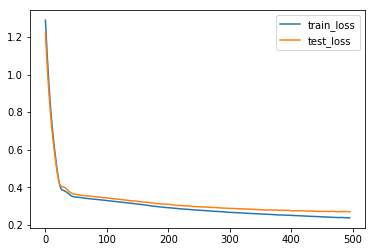

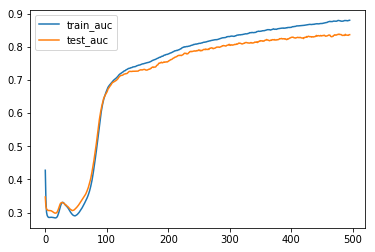

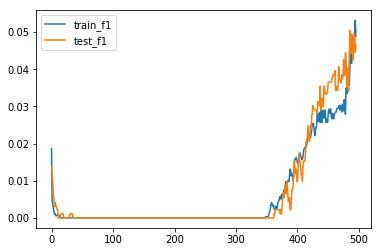

iter 550 train_loss 0.22973105311393738 test_loss 0.2695790231227875
iter 550 train_f1 0.1218637992831541 test_f1 0.06806282722513089

iter 600 train_loss 0.22374674677848816 test_loss 0.26619231700897217
iter 600 train_f1 0.13439306358381503 test_f1 0.09090909090909091

iter 650 train_loss 0.217688649892807 test_loss 0.26693233847618103
iter 650 train_f1 0.19687712152070602 test_f1 0.0911392405063291

iter 700 train_loss 0.21188399195671082 test_loss 0.26429927349090576
iter 700 train_f1 0.23793787177792466 test_f1 0.0906801007556675

iter 750 train_loss 0.20731210708618164 test_loss 0.26623573899269104
iter 750 train_f1 0.23847167325428198 test_f1 0.15274463007159905

iter 800 train_loss 0.20267990231513977 test_loss 0.2659575939178467
iter 800 train_f1 0.30253164556962026 test_f1 0.12530120481927712

iter 850 train_loss 0.19981472194194794 test_loss 0.2651693820953369
iter 850 train_f1 0.3416413373860182 test_f1 0.17674418604651163

iter 900 train_loss 0.1943524330854416 test_loss 0

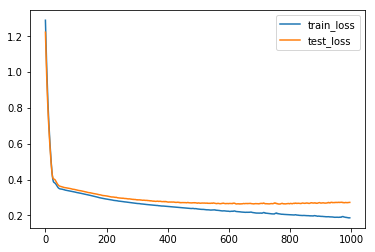

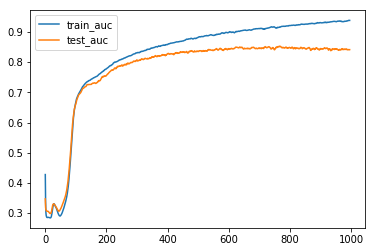

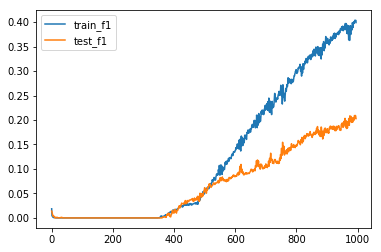

In [39]:
stats_noisy = train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

In [40]:
predicted_probality = RnnPredictor(model_noisy).predict_proba(X_test, device)

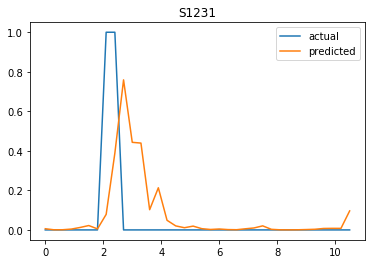

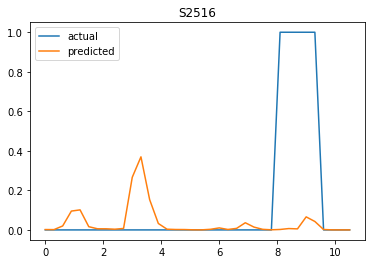

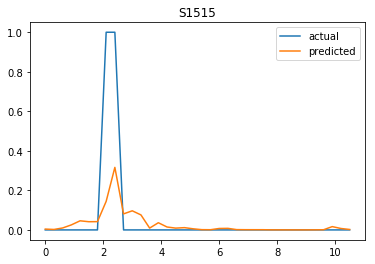

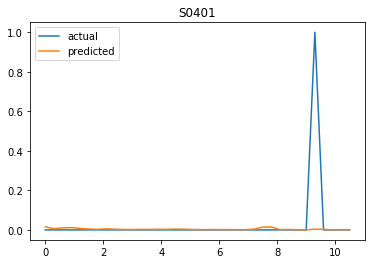

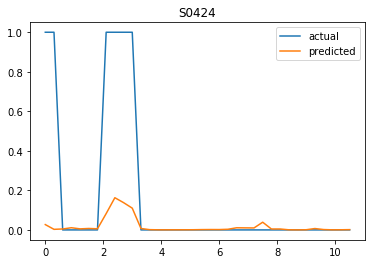

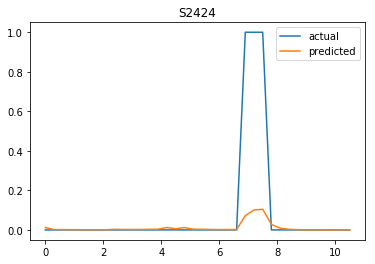

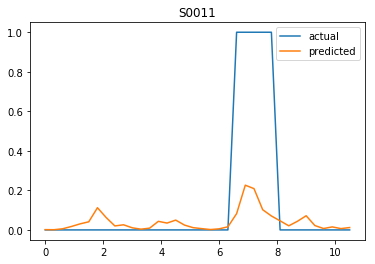

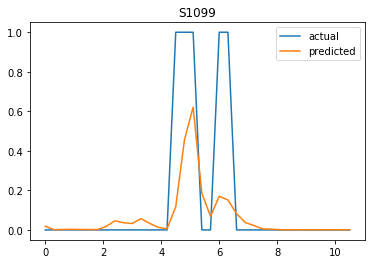

In [41]:
for sname, actual, pred in zip(snames_test[:32], y_test, predicted_probality):
    if np.sum(actual) != 0:
        plt.title(sname)
        l = len(actual)
        plt.plot(np.arange(l) * FRAME_SEC, actual, label='actual')
        plt.plot(np.arange(l) * FRAME_SEC, pred, label='predicted')
        plt.legend()
        plt.show()


## Обучаем модель на данных без добавленного шума

In [42]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data)

In [43]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [44]:
model_clean = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_clean = model_clean.to(device)
train_iter = 1

iter 50 train_loss 0.3620718717575073 test_loss 0.3764140009880066
iter 50 train_f1 0.0 test_f1 0.0

iter 100 train_loss 0.3352125883102417 test_loss 0.34943678975105286
iter 100 train_f1 0.0 test_f1 0.0

iter 150 train_loss 0.3094971776008606 test_loss 0.32331153750419617
iter 150 train_f1 0.0 test_f1 0.005434782608695652

iter 200 train_loss 0.29108530282974243 test_loss 0.3059556782245636
iter 200 train_f1 0.0 test_f1 0.0

iter 250 train_loss 0.2738949656486511 test_loss 0.2878876030445099
iter 250 train_f1 0.0 test_f1 0.0

iter 300 train_loss 0.2595312297344208 test_loss 0.27623069286346436
iter 300 train_f1 0.0 test_f1 0.0

iter 350 train_loss 0.24914097785949707 test_loss 0.268555611371994
iter 350 train_f1 0.0031645569620253164 test_f1 0.0

iter 400 train_loss 0.24333207309246063 test_loss 0.26160550117492676
iter 400 train_f1 0.018764659890539485 test_f1 0.021621621621621623

iter 450 train_loss 0.23692867159843445 test_loss 0.2606485188007355
iter 450 train_f1 0.05900151285930

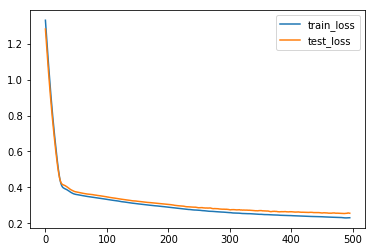

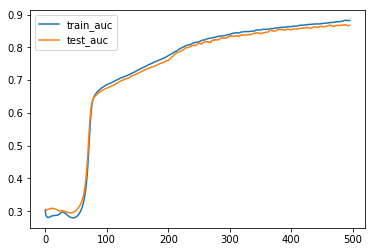

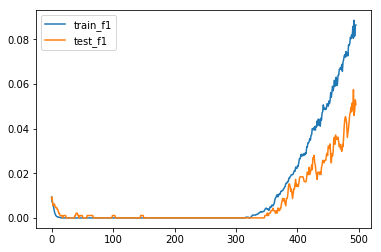

iter 550 train_loss 0.22205981612205505 test_loss 0.2525641918182373
iter 550 train_f1 0.11005135730007336 test_f1 0.052910052910052914

iter 600 train_loss 0.22028926014900208 test_loss 0.24735066294670105
iter 600 train_f1 0.12445730824891463 test_f1 0.11000000000000001

iter 650 train_loss 0.2107483148574829 test_loss 0.24944984912872314
iter 650 train_f1 0.18029350104821804 test_f1 0.08163265306122448

iter 700 train_loss 0.209019735455513 test_loss 0.24914506077766418
iter 700 train_f1 0.2501628664495114 test_f1 0.14218009478672985

iter 750 train_loss 0.2025432586669922 test_loss 0.24677565693855286
iter 750 train_f1 0.2966687617850408 test_f1 0.13592233009708737

iter 800 train_loss 0.1998826265335083 test_loss 0.25169092416763306
iter 800 train_f1 0.315136476426799 test_f1 0.11650485436893203

iter 850 train_loss 0.19325345754623413 test_loss 0.24824681878089905
iter 850 train_f1 0.3252336448598131 test_f1 0.16317016317016317

iter 900 train_loss 0.19035595655441284 test_loss 0

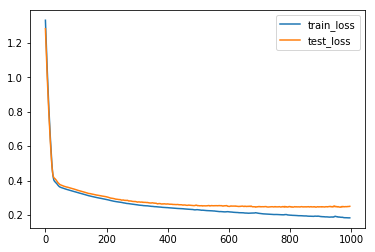

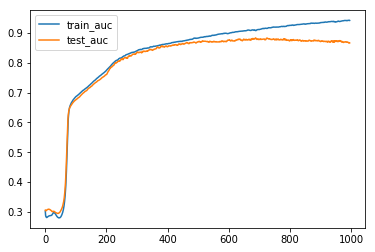

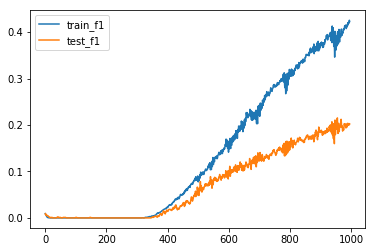

''

In [45]:
stats_сlean = train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)
;

## Сравнение моделей

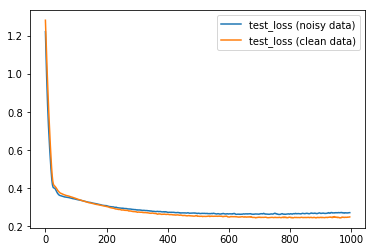

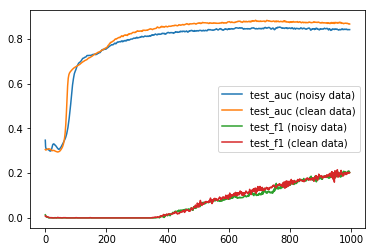

In [46]:
plt.plot(window_mean(stats_noisy.test_losses), label='test_loss (noisy data)')
plt.plot(window_mean(stats_сlean.test_losses), label='test_loss (clean data)')

plt.legend()
plt.show()

plt.plot(window_mean(stats_noisy.test_auc), label='test_auc (noisy data)')
plt.plot(window_mean(stats_сlean.test_auc), label='test_auc (clean data)')
plt.plot(window_mean(stats_noisy.test_f1), label='test_f1 (noisy data)')
plt.plot(window_mean(stats_сlean.test_f1), label='test_f1 (clean data)')

plt.legend()
plt.show()

In [47]:
_, X_test_noisy, _, y_test_noisy, _, sname_test_noisy = split(data_noisy)

In [48]:
snames_test == sname_test_noisy

True

In [49]:
scores_noisy = RnnPredictor(model_noisy).predict_proba(X_test_noisy, device)
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_noisy, device)

In [50]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(testy, scores, label=''):
    plt.title('precision recall curve')
    precision, recall, thresholds = precision_recall_curve(testy, scores)
    plt.plot(recall, precision, label=label)
    plt.xlabel('recall')
    plt.ylabel('precision')

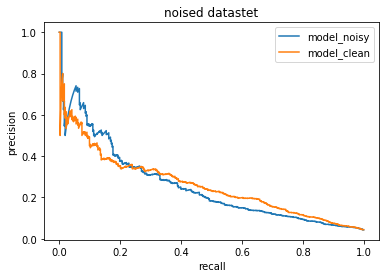

In [51]:
plot_pr_curve(y_test_noisy.ravel(), scores_noisy.ravel(), 'model_noisy')
plot_pr_curve(y_test_noisy.ravel(), scores_clean.ravel(), 'model_clean')
plt.title('noised datastet')
    
plt.legend()
plt.show()

In [52]:
_, X_test_clean, _, y_test_clean, _, sname_test_clean = split(data)

In [53]:
scores_noisy = RnnPredictor(model_noisy).predict_proba(X_test_clean, device)
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_clean, device)

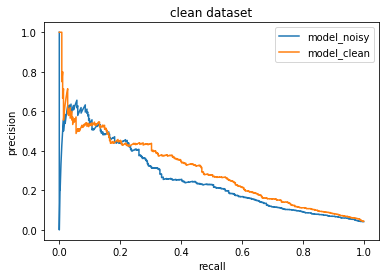

In [54]:
plot_pr_curve(y_test_noisy.ravel(), scores_noisy.ravel(), 'model_noisy')
plot_pr_curve(y_test_noisy.ravel(), scores_clean.ravel(), 'model_clean')
plt.title('clean dataset')
plt.legend()
plt.show()

## Cохранение моделей

In [55]:
torch.save(model_noisy.state_dict(), 'models/rnn_model_for_noisy_dataset.ptr')

In [56]:
torch.save(model_clean.state_dict(), 'models/rnn_model_for_clean_dataset.ptr')